Experimentation on the CIFAR simmulated annotators
* batch = 128
* delta convergence = $3\cdot 10^{-2}$
* Optimizer = ADAM

* Our proposed: Pre-train base model with hard-MV (5 epochs?) as Rodrigues: https://github.com/fmpr/CrowdLayer/blob/master/demo-conll-ner-mturk.ipynb

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras, time, sys, os, gc

DTYPE_OP = 'float32'
keras.backend.set_floatx(DTYPE_OP)

if DTYPE_OP == 'float64':
    keras.backend.set_epsilon(np.finfo(np.float64).eps)
elif DTYPE_OP == 'float32':
    keras.backend.set_epsilon(np.finfo(np.float32).eps)

Using TensorFlow backend.


In [2]:
#GLOBAL Variables
BATCH_SIZE = 128
EPOCHS_BASE = 50
OPT = 'adam' #optimizer for neural network 
TOL = 3e-2 #tolerance for relative variation of parameters
#o 2?

### Load Data and preprocess

In [3]:
from keras.datasets import cifar10
(X_train, Z_train), (X_test, Z_test) = cifar10.load_data()
print("Input shape:",X_train.shape)

170500096/170498071 [==============================] - 66s 0us/step
Input shape: (50000, 32, 32, 3)


In [4]:
Xstd_train = X_train.astype(DTYPE_OP)/255
Xstd_test = X_test.astype(DTYPE_OP)/255
Z_train = Z_train[:,0]
Z_test = Z_test[:,0]
Xstd_train.shape

(50000, 32, 32, 3)

### Load annotations

In [5]:
#opt = "CIFAR_normal"
#opt = "CIFAR_normal_badMV"
opt = "CIFAR_normal_soft" 
#opt = "CIFAR_manyAnnot_v1" #npy
#opt = "CIFAR_manyAnnot_v2" #npy
#opt = "CIFAR_manyAnnot_v1_badMV" #npy

In [6]:
y_obs = np.loadtxt("../syntetic/CIFAR/annotations_"+opt+".csv" ,delimiter=',',dtype='int')
#y_obs = np.load("../syntetic/CIFAR/annotations_"+opt+".npy" )

groups_annot = np.loadtxt("../syntetic/CIFAR/annotgroups_"+opt+".csv",delimiter=',')
#groups_annot = np.load("../syntetic/CIFAR/annotgroups_"+opt+".npy")

load_matrix = np.loadtxt('../syntetic/CIFAR/matrix_CIFAR_normal.csv',delimiter=',')
#load_matrix = np.loadtxt('../syntetic/CIFAR/matrix_CIFAR_badMV.csv',delimiter=',')

rows,Kl = load_matrix.shape
real_conf_matrix = np.asarray([load_matrix[j-Kl:j] for j in np.arange(Kl,rows+1,Kl)])
if len(groups_annot.shape) ==1 or groups_annot.shape[1] ==  1: 
    groups_annot = keras.utils.to_categorical(groups_annot)  #only if it is hard clustering
    print("Done")
confe_matrix = np.tensordot(groups_annot,real_conf_matrix, axes=[[1],[0]])

N,T = y_obs.shape
K = np.max(y_obs)+1 # asumiendo que estan ordenadas
print("Shape (data,annotators): ",(N,T))
print("Classes: ",K)

Shape (data,annotators):  (50000, 100)
Classes:  10


In [5]:
scenario = 2
path = "."

In [10]:
from code.generate_data import SinteticData

GenerateData = SinteticData()

#CONFUSION MATRIX CHOOSE
if scenario == 1 or scenario == 3 or scenario == 4 or scenario == 5 or scenario == 6:
    GenerateData.set_probas(asfile=True,file_matrix=path+'/synthetic/CIFAR/matrix_CIFAR_normal.csv',file_groups =path+'/synthetic/CIFAR/groups_CIFAR_normal.csv')

elif scenario == 2 or scenario == 7: #bad MV
    GenerateData.set_probas(asfile=True,file_matrix=path+'/synthetic/CIFAR/matrix_CIFAR_badMV.csv',file_groups =path+'/synthetic/CIFAR/groups_CIFAR_badMV.csv')
    #GenerateData.set_probas(asfile=False,file_matrix=aux1,file_groups =aux2)

real_conf_matrix = GenerateData.conf_matrix.copy()

#ANNOTATOR DENSITY CHOOSE
if scenario == 1 or scenario ==2 or scenario == 3:
    Tmax = 100
    T_data = 10 
elif scenario == 4 or scenario == 7:
    Tmax = 2000
    T_data = 20 
elif scenario == 5:
    Tmax = 5000
    T_data = 25
elif scenario == 6:
    Tmax = 10000
    T_data = 40
    
#GenerateData.set_probas(asfile=False,file_matrix=real_conf_matrix,file_groups =aux)

print("New Synthetic data is being generated...",flush=True,end='')
if scenario == 3: #soft
    y_obs, groups_annot = GenerateData.sintetic_annotate_data(Z_train,Tmax,T_data,deterministic=False,hard=False)
else:
    y_obs, groups_annot = GenerateData.sintetic_annotate_data(Z_train,Tmax,T_data,deterministic=False)
print("Done! ")

if len(groups_annot.shape) ==1 or groups_annot.shape[1] ==  1: 
    groups_annot = keras.utils.to_categorical(groups_annot)  #only if it is hard clustering
confe_matrix = np.tensordot(groups_annot,real_conf_matrix, axes=[[1],[0]])

print("Accuracy of MV on train: ",np.mean(majority_voting(y_obs,repeats=False,onehot=False) == Z_train))

N,T = y_obs.shape
K = np.max(y_obs)+1 # asumiendo que estan ordenadas
print("Shape (data,annotators): ",(N,T))
print("Classes: ",K)

New Synthetic data is being generated...Done! 
Accuracy of MV on train:  0.62874
Shape (data,annotators):  (50000, 100)
Classes:  10


#### Delta Convergence criteria

In [8]:
from code.learning_models import LogisticRegression_Sklearn,LogisticRegression_Keras,MLP_Keras
#deep learning
from code.learning_models import default_CNN,default_RNN,default_RNNw_emb,CNN_simple, RNN_simple

from code.utils import EarlyStopRelative
ourCallback = EarlyStopRelative(monitor='loss',patience=1,min_delta=TOL)

### Upper Bound Model -- ideal

In [36]:
Z_train_onehot = keras.utils.to_categorical(Z_train)

model_UB = default_CNN(Xstd_train.shape[1:],Z_train_onehot.shape[1])

model_UB.compile(loss='categorical_crossentropy',optimizer=OPT)
model_UB.fit(Xstd_train,Z_train_onehot,epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])

In [7]:
from code.representation import *
from code.utils import *

### Infer Labels (without predictive model)

In [11]:
from code.baseline import LabelInference

label_I = LabelInference(y_obs,TOL,type_inf = 'all')
#label_I = LabelInference(y_obs_categorical,TOL, type_inf = 'all')

mv_probas = label_I.mv_labels('probas')
mv_onehot = label_I.mv_labels('onehot')

ds_labels,ds_conf = label_I.DS_labels()

Iter	log-likelihood	delta-CM	delta-ER	delta-LL
1 	 -748435.2769339099
2 	 -738678.5636047325 	0.1859	0.277558	0.013036
3 	 -736894.2568785188 	0.0597	0.140429	0.002416
4 	 -736458.4296218698 	0.0335	0.091128	0.000591
5 	 -736306.2971674779 	0.0231	0.063493	0.000207
6 	 -736239.2227562398 	0.0161	0.047890	0.000091
7 	 -736205.0286785546 	0.0114	0.038476	0.000046
8 	 -736186.0061782977 	0.0082	0.031349	0.000026
9 	 -736174.8047757423 	0.0060	0.025954	0.000015
Class marginals
[0.1  0.1  0.09 0.08 0.1  0.12 0.11 0.1  0.1  0.1 ]


In [14]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))
print("ACC D&S on train:",np.mean(ds_labels.argmax(axis=1)==Z_train))

ACC MV on train: 0.62874
ACC D&S on train: 0.77286


In [15]:
model_mvsoft = default_CNN(Xstd_train.shape[1:],mv_probas.shape[1])
model_mvsoft.compile(loss='categorical_crossentropy',optimizer=OPT)
model_mvsoft.fit(Xstd_train, mv_probas, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0)
print("Trained model over soft-MV")

KeyboardInterrupt: 

In [ ]:
model_mvhard = default_CNN(Xstd_train.shape[1:],mv_onehot.shape[1])
model_mvhard.compile(loss='categorical_crossentropy',optimizer=OPT)
model_mvhard.fit(Xstd_train, mv_onehot, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0)
print("Trained model over hard-MV")

In [ ]:
model_ds = default_CNN(Xstd_train.shape[1:],ds_labels.shape[1])
model_ds.compile(loss='categorical_crossentropy',optimizer=OPT)
model_ds.fit(Xstd_train, ds_labels, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0)
print("Trained model over D&S")

In [ ]:
y_obs_categorical = label_I.y_obs_categ
#y_obs_categorical = set_representation(y_obs,'onehot') #for raykar & MV

### Raykar Model (joint predict model)

from baseline import RaykarMC

raykarMC = RaykarMC(Xstd_train.shape[1:],y_obs_categorical.shape[-1],T,epochs=1,optimizer=OPT,DTYPE_OP=DTYPE_OP)
raykarMC.define_model("default cnn")

raykarMC.define_priors(np.ones((T,K))) #cada observador dijo al menos un dato
logL_hist = raykarMC.train(Xstd_train,y_obs_categorical,batch_size=BATCH_SIZE,iterations=EPOCHS_BASE,tolerance=TOL
                           ,relative=True,val=False)

In [ ]:
from code.baseline import RaykarMC

raykarMC = RaykarMC(Xstd_train.shape[1:],y_obs_categorical.shape[-1],T,epochs=1,optimizer=OPT,DTYPE_OP=DTYPE_OP)
raykarMC.define_model("default cnn")

logL_hists,i = raykarMC.multiples_run(10,Xstd_train,y_obs_categorical,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,
                                     tolerance=TOL)

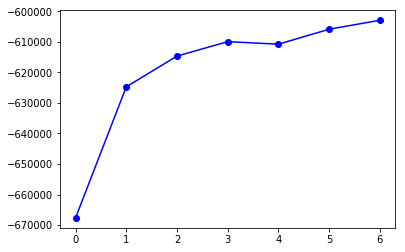

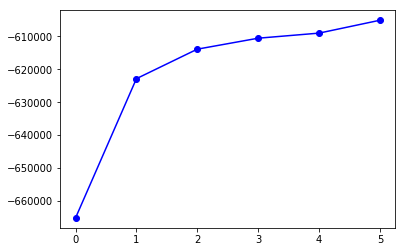

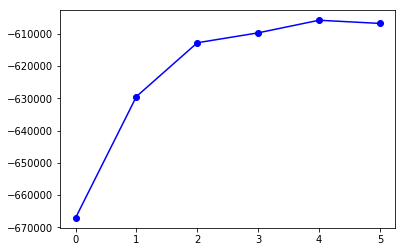

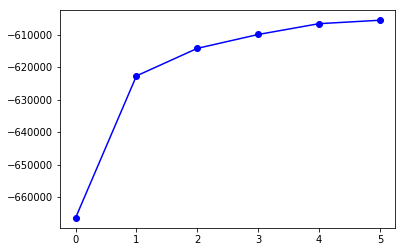

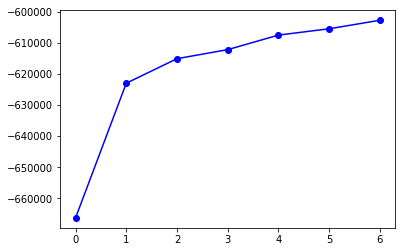

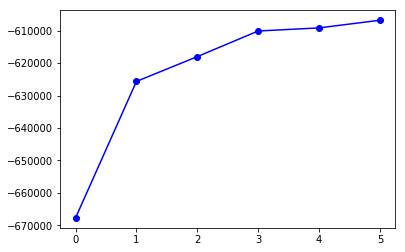

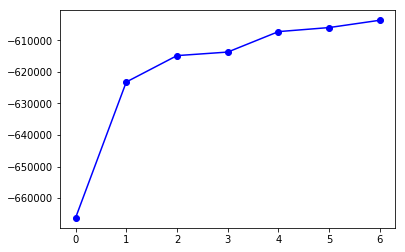

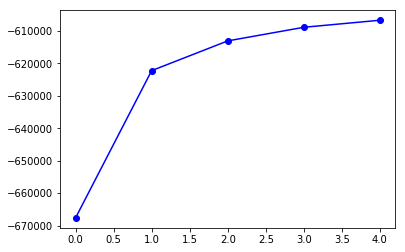

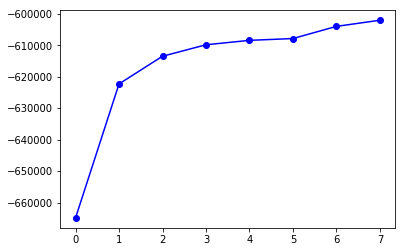

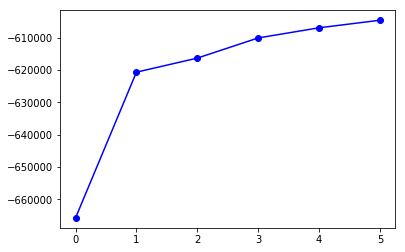

In [20]:
for value in logL_hists:
    plt.plot(range(len(value)),value,'bo-')
    plt.show()

### Our Proposed

In [ ]:
from code.MixtureofGroups import GroupMixtureOpt
#get our representation 
r_obs = set_representation(y_obs_categorical,"repeat")
#r_obs = set_representation(y_obs,"repeat")
print("vector of repeats:\n",r_obs)
print("shape:",r_obs.shape)

In [ ]:
%%time

#pre analysis
from code.MixtureofGroups import project_and_cluster,clusterize_annotators
if y_obs_categorical.shape[1] > 3000:
    annotators_pca = project_and_cluster(y_obs_categorical,DTYPE_OP=DTYPE_OP,printed=False,mode_project="tpca")[0]
else:
    annotators_pca = project_and_cluster(y_obs_categorical,DTYPE_OP=DTYPE_OP,printed=False,mode_project="pca")[0]
print("Annotators PCA of annotations shape: ",annotators_pca.shape)

#mv_soft = majority_voting(r_obs,repeats=True,probas=True) 
#aux = []
#for example in mv_soft:
#    aux.append(entropy(example)/np.log(K))
#print("Normalized entropy (0-1) of repeats annotations:",np.mean(aux))

In [ ]:
M_seted = 4

In [ ]:
gMixture1 = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=M_seted,epochs=1,pre_init=5,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture1.define_model("default cnn")
gMixture1.lambda_random = False #lambda=1     
logL_hists,i = gMixture1.multiples_run(10,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL
                                   ,cluster=True,bulk_annotators=[y_obs_categorical,annotators_pca])

In [ ]:
gMixture2 = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=M_seted,epochs=1,pre_init=5,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture2.define_model("default cnn")
gMixture2.lambda_random = True #lambda random
logL_hists,i = gMixture2.multiples_run(10,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL
                                   ,cluster=True,bulk_annotators=[y_obs_categorical,annotators_pca])

In [ ]:
gMixture3 = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=M_seted,epochs=1,pre_init=5,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture3.define_model("default cnn")
gMixture3.lambda_random = True #with lambda random --necessary
logL_hists,i = gMixture3.multiples_run(10,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL
                                   ,cluster=True)

### Compare trained models

In [ ]:
#Import it:
from code.evaluation import Evaluation_metrics
from sklearn.metrics import confusion_matrix

In [22]:
evaluate = Evaluation_metrics(model_UB,'keras',Xstd_train.shape[0])
print("*** Upper bound -- Ideal (Train with GT) ***")

print("Train")
Z_train_pred = evaluate.tested_model.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred)

print("Test")
Z_test_pred = evaluate.tested_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Upper bound (Train with GT) ***
Train
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |    0.98448 |      0.98448 |
+----+--------+------------+--------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |     0.8084 |       0.8084 |
+----+--------+------------+--------------+


#### 1st configuration: Normal ($T$ = 100, $T_{max}$ = 10 )

In [23]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.731


In [22]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
Z_train_p = model_mvsoft.predict(Xstd_train)
prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvsoft.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

NameError: name 'Evaluation_metrics' is not defined

In [ ]:
print("*** Soft-Majority (Train with softMV) ***")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

In [25]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
Z_train_p = model_mvhard.predict(Xstd_train)
prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvhard.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***
Train
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |    0.73518 |      0.73518 |
+----+--------+------------+--------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |     0.6255 |       0.6255 |
+----+--------+------------+--------------+


In [ ]:
print("*** Hard-Majority (Train with hardMV) ***")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

In [26]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
Z_train_pred = model_ds.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf_M,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_ds.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Dawid and Skene model (Train with D&S) ***
Train
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |    0.90564 |      0.90564 |
+----+--------+------------+--------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |     0.7655 |       0.7655 |
+----+--------+------------+--------------+


*** Raykar model multiples runs***
Train


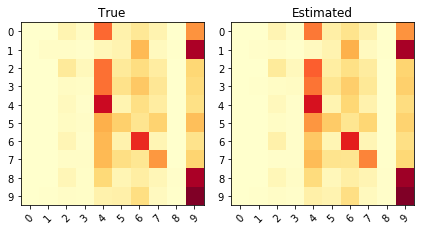

KL divergence: 0.0104	Pearson Correlation between diagonals: 0.9980


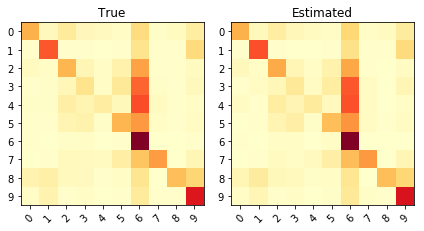

KL divergence: 0.0081	Pearson Correlation between diagonals: 0.9971


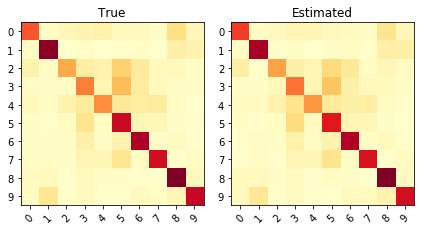

KL divergence: 0.0095	Pearson Correlation between diagonals: 0.9856


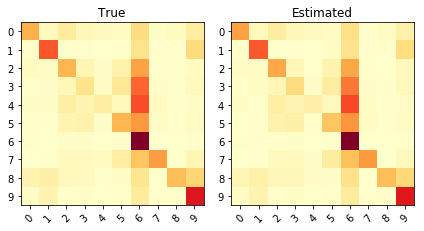

KL divergence: 0.0102	Pearson Correlation between diagonals: 0.9928


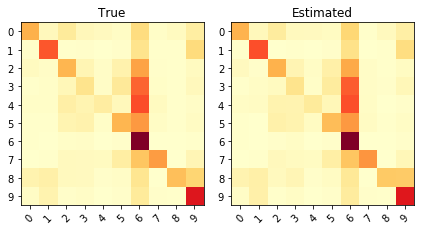

KL divergence: 0.0083	Pearson Correlation between diagonals: 0.9975


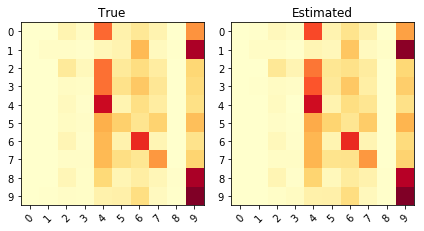

KL divergence: 0.0119	Pearson Correlation between diagonals: 0.9998


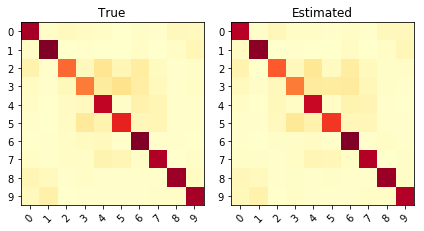

KL divergence: 0.0109	Pearson Correlation between diagonals: 0.9903


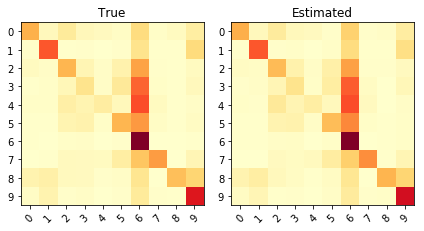

KL divergence: 0.0088	Pearson Correlation between diagonals: 0.9966


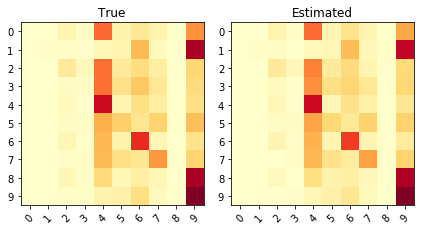

KL divergence: 0.0134	Pearson Correlation between diagonals: 0.9991


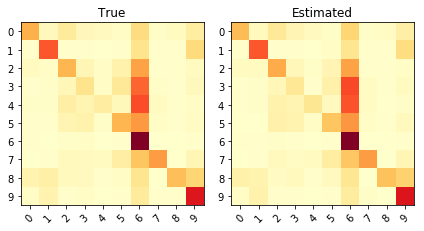

KL divergence: 0.0101	Pearson Correlation between diagonals: 0.9947


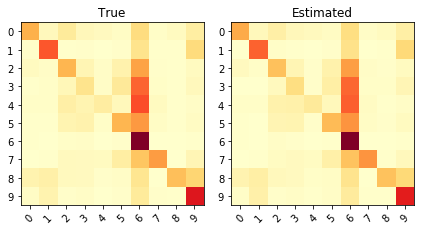

KL divergence: 0.0085	Pearson Correlation between diagonals: 0.9961


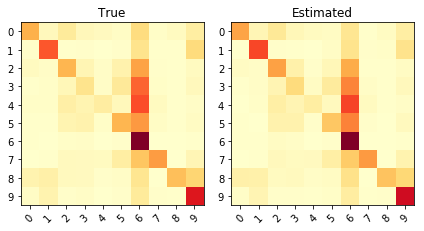

KL divergence: 0.0128	Pearson Correlation between diagonals: 0.9907


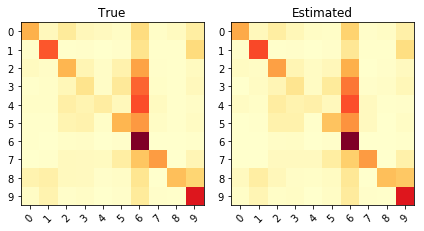

KL divergence: 0.0140	Pearson Correlation between diagonals: 0.9933


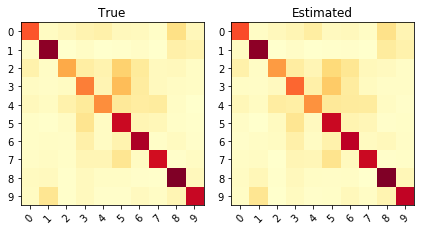

KL divergence: 0.0084	Pearson Correlation between diagonals: 0.9944


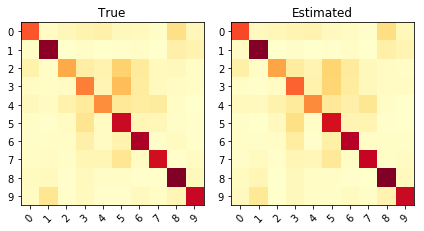

KL divergence: 0.0080	Pearson Correlation between diagonals: 0.9929
A result
 +----+--------+------------+--------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------+--------------+-----------------------+----------------|
|  0 | Global |    0.83208 |      0.83208 |    0.0102645 |              0.994363 |      0.0946073 |
+----+--------+------------+--------------+--------------+-----------------------+----------------+
A result
 +----+------------------------------+-----------------------------------+
|    |   Accuracy imiting Annotator |   Cross-entropy imiting Annotator |
|----+------------------------------+-----------------------------------|
|  0 |                     0.522795 |                           1.41284 |
+----+------------------------------+-----------------------------------+
Test
A result
 +----+--------+------------

In [27]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
Z_train_pred = raykarMC.base_model.predict_classes(Xstd_train)
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
Z_test_pred = raykarMC.base_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

In [ ]:
evaluate = Evaluation_metrics(gMixture1,'our1') 
aux = gMixture1.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (1) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture1.base_model.predict_classes(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture1.get_confusionM()
y_o_groups = gMixture1.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture1.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

In [ ]:
evaluate = Evaluation_metrics(gMixture2,'our1') 
aux = gMixture2.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (2) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture2.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture2.get_confusionM()
y_o_groups = gMixture2.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture2.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

In [ ]:
evaluate = Evaluation_metrics(gMixture3,'our1') 
aux = gMixture3.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (3) multiples runs***") #lambda = random

print("Train")
Z_train_pred = gMixture3.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture3.get_confusionM()
y_o_groups = gMixture3.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture3.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

#### 2) configuration: very bad MV ($T$ = 100, $T_{max}$ = 10 )

In [40]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.61904


In [41]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
Z_train_p = model_mvsoft.predict(Xstd_train)
prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvsoft.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Soft-Majority (Train with softMV) ***
Train
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |    0.65386 |      0.65386 |
+----+--------+------------+--------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |     0.5362 |       0.5362 |
+----+--------+------------+--------------+


In [ ]:
print("*** Soft-Majority (Train with softMV) ***")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

In [ ]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
Z_train_p = model_mvhard.predict(Xstd_train)
prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvhard.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

In [ ]:
print("*** Hard-Majority (Train with hardMV) ***")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

In [ ]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
Z_train_pred = model_ds.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf_M,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_ds.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Raykar model multiples runs***
Train


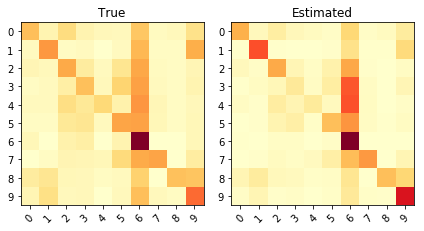

KL divergence: 0.1091	Pearson Correlation between diagonals: 0.9103


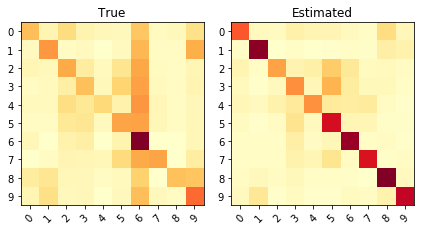

KL divergence: 0.5115	Pearson Correlation between diagonals: 0.4924


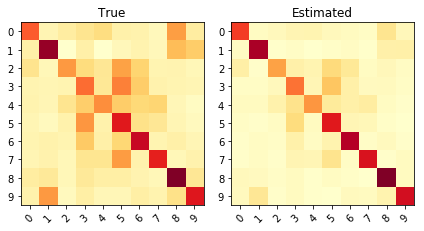

KL divergence: 0.1431	Pearson Correlation between diagonals: 0.9804


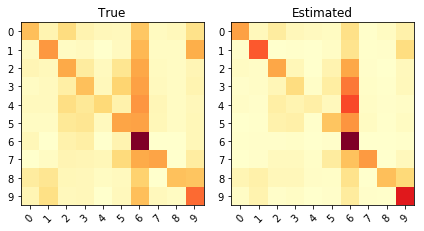

KL divergence: 0.1253	Pearson Correlation between diagonals: 0.9178


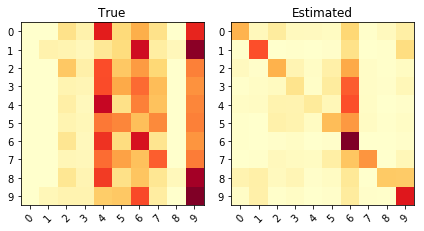

KL divergence: 1.0133	Pearson Correlation between diagonals: 0.4230


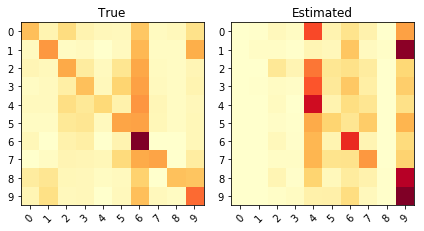

KL divergence: 0.9245	Pearson Correlation between diagonals: 0.4265


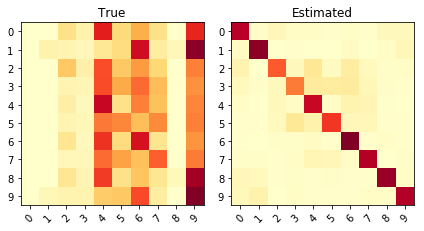

KL divergence: 1.4181	Pearson Correlation between diagonals: 0.2253


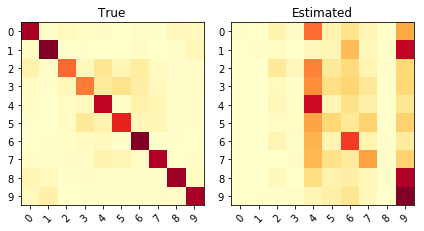

KL divergence: 1.7307	Pearson Correlation between diagonals: 0.3033


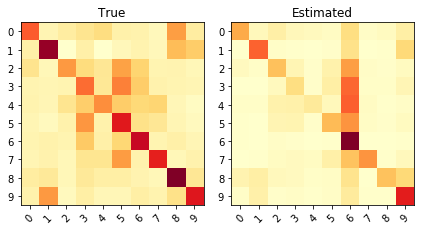

KL divergence: 0.5230	Pearson Correlation between diagonals: 0.4977


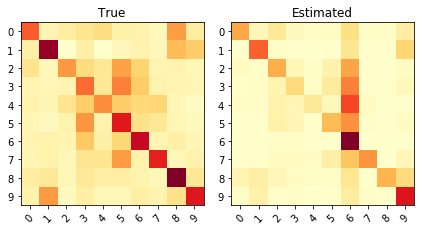

KL divergence: 0.5176	Pearson Correlation between diagonals: 0.4923


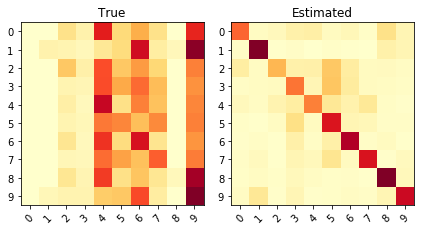

KL divergence: 1.1998	Pearson Correlation between diagonals: 0.0419


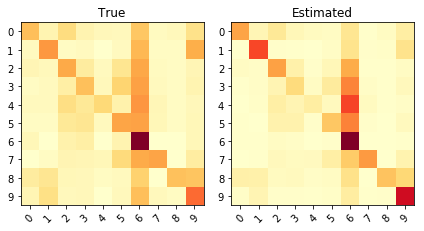

KL divergence: 0.1286	Pearson Correlation between diagonals: 0.9009


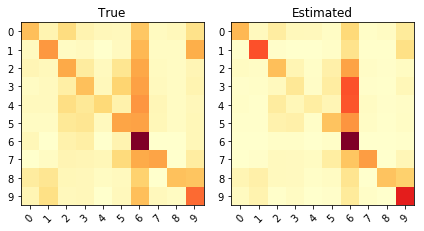

KL divergence: 0.1178	Pearson Correlation between diagonals: 0.9217


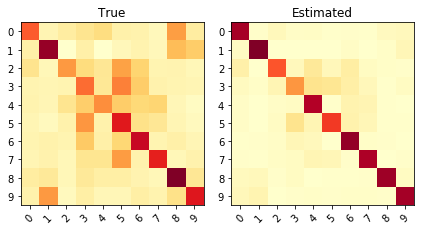

KL divergence: 0.5006	Pearson Correlation between diagonals: 0.5828


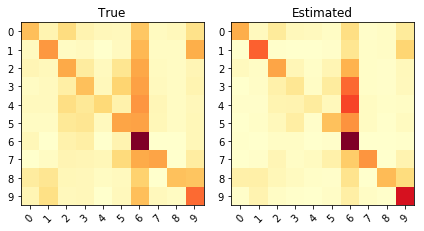

KL divergence: 0.1212	Pearson Correlation between diagonals: 0.9124
A result
 +----+--------+------------+--------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------+--------------+-----------------------+----------------|
|  0 | Global |    0.83208 |      0.83208 |     0.536451 |              0.579864 |      0.0650388 |
+----+--------+------------+--------------+--------------+-----------------------+----------------+
A result
 +----+------------------------------+-----------------------------------+
|    |   Accuracy imiting Annotator |   Cross-entropy imiting Annotator |
|----+------------------------------+-----------------------------------|
|  0 |                     0.298993 |                           2.24538 |
+----+------------------------------+-----------------------------------+
Test
A result
 +----+--------+------------

In [44]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
Z_train_pred = raykarMC.base_model.predict_classes(Xstd_train)
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
Z_test_pred = raykarMC.base_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

In [ ]:
evaluate = Evaluation_metrics(gMixture1,'our1') 
aux = gMixture1.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (1) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture1.base_model.predict_classes(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture1.get_confusionM()
y_o_groups = gMixture1.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture1.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

In [ ]:
evaluate = Evaluation_metrics(gMixture2,'our1') 
aux = gMixture2.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (2) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture2.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture2.get_confusionM()
y_o_groups = gMixture2.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture2.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

In [ ]:
evaluate = Evaluation_metrics(gMixture3,'our1') 
aux = gMixture3.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (3) multiples runs***") #lambda = random

print("Train")
Z_train_pred = gMixture3.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture3.get_confusionM()
y_o_groups = gMixture3.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture3.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

#### 3) configuration: normal soft ($T$ = 100, $T_{max}$ = 10, soft clustering )

In [17]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.7265145302906059


#### 4) configuration: Manny annot v1 ($T$ = 2000, $T_{max}$ = 20 )

In [ ]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))